In [1]:
import pandas as pd
import folium # 地图绘制工具
from pyproj import Transformer # 用于地理坐标转换
import datetime # 处理日期和时间，可进行日期和时间的加减、格式化、比较等
import time # 处理时间

from geographiclib.geodesic import Geodesic
#用于计算地球上大圆线和小圆弧

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

In [2]:
def utcsec2str(s, f='%Y-%m-%d %H:%M:%S'):
    """utc秒数转换为时间字符串,
    datetime库中datetime类的utcfromtimestamp()方法,将Unix时间戳转换为UTC时间的datetime对象;
    strftime():将一个datetime对象格式化为字符串"""
    return datetime.datetime.utcfromtimestamp(s).strftime(f)

# def traj_from_wkt(the_wkt):
#     "轨迹WKT字符串转换为轨迹对象"
#     the_wkt = the_wkt.strip()
#     data = [[float(y) 
#           for y in x.split(" ")] for x in the_wkt[the_wkt.index("(") + 1:the_wkt.index(")")].split(",")]
#     return data

# 轨迹可视化风格
# weight为像素宽度，opacity：折线不透明度（0-1之间的浮点数），color：折线颜色
# stroke：是否沿路径绘制笔划。将其设置为false可禁用多边形或圆上的边界
# radius:圆形标记的像素半径，fill：是否填充，fillColor：填充颜色，fillOpacity:填充不透明度
traj_default_folium_theme = {
    'traj_line_props': {
        'weight': 2,
        'stroke': True,
        'opacity': 0.5,
        'color': 'red'
    },
    'traj_point_props': {
        'radius': 1,
        'weight': 1,
        'color': 'green',
        'opacity': 1,
        'fill': True,
        'fillColor': 'green',
        'fillOpacity': 0.5
    }
}

def traj_to_folium(m: folium.map,
                   traj,
                   show_line: bool = True, 
                   show_point: bool = True,
                   show_pt_time_tip: bool = True,
                   zoom_to_traj:bool = False,
                   traj_line_props: dict = traj_default_folium_theme['traj_line_props'],
                   traj_point_props: dict = traj_default_folium_theme['traj_point_props']
                   ):
    """使用Folium可视化轨迹函数"""
    data = traj
    coords = [(p[2], p[1]) for p in data] # (纬度，经度)坐标的列表
    
    if show_line: #展示行迹折线
        line = folium.PolyLine(coords, **traj_line_props) # 创建地图上的折线层
        # 带有 ** 的参数：可变关键字参数，可接收任意数量的关键字参数，并将这些参数打包成一个字典传递给函数
        line.add_to(m) # 将折线图层加到map对象
        
    # folium.CircleMarker():在地图上指定位置创建圆形标记
    if show_point: #展示信息点
        for p in data:
            if show_pt_time_tip:
                tip = utcsec2str(int(p[0])) # 时间字符串
            folium.CircleMarker([p[2], p[1]], tooltip=tip, **traj_point_props).add_to(m)
            
    #get_bounds()：获取地图对象的边界框（bounding box），即元组 (southwest, northeast)
    # southwest 和 northeast 分别是左下角和右上角的经纬度坐标
    # fit_bounds()：用于自动缩放地图，使其适合指定的边界框
    if zoom_to_traj: # 缩放行迹
        m.fit_bounds(line.get_bounds())

In [3]:
def timestr2sec(s,f='%Y-%m-%d %H:%M:%S.000000'):
    """将字符串解析为时间对象,再转换为时间戳"""
    return time.mktime(time.strptime(s,f))
# time.strptime()：将字符串解析为时间对象
# time.mktime():将一个struct_time对象转换为时间戳(从1970年1月1日0时开始到现在的秒数)

# iterrows()方法：用于迭代DateFrame中的每一行数据；返回一个生成器对象
# 生成器对象每次迭代返回一个元组(行索引，该行series对象),其中series对象中索引为列名，值为该行数据对应列的值
def getTrajByMMSI(mmsi):
    """由mmsi信息筛选得到数据中某个船只的数据;
        将basedatetime列转换为Unix时间戳;
        生成列表[Unix,经度,纬度]表示该船只的行迹,按照Unix大小排序"""
    pts = [(timestr2sec(r["basedatetime"]),r["lon"],r["lat"]) 
           for x,r in df_ais_pts[df_ais_pts["mmsi"]==mmsi][["basedatetime","lon","lat"]].iterrows()]
    pts.sort(key=lambda p:p[0]) # 将列表按照时间戳大小排序
    return pts

In [4]:
def plot_traj_to_folium(mmsi):
    """把船的行迹在地图上显示"""
    traj = getTrajByMMSI(mmsi) # [Unix,经度,纬度]
    figure = folium.Figure(width=1000, height=500) # 创建一个包含一个或多个地图的Figure对象
    map = folium.Map() # 创建地图对象

# folium.TileLayer(tiles,attr).add_to(map):添加基础地图图层到地图对象中
# tiles：地图样式,attr:图层属性，用于指定地图图层版权信息
    folium.TileLayer(
        tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}", 
        attr="ESRI IMAGERY").add_to(map) 
    map.add_to(figure) # 将地图对象添加到figure对象中
    traj_to_folium(map, traj, zoom_to_traj=True) # 将行迹可视化，自动缩放到折线的边界框
    return map

def plot_traj_point_scatter(mmsi):
    """把船的行迹在坐标轴上显示"""
    df_ais_pts_1=df_ais_pts[df_ais_pts['mmsi'] == mmsi]
    position = df_ais_pts_1[['lat','lon']]
    return position.plot.scatter(x='lon',y='lat',
                                 figsize=(12,5),color='blue',
                                 title='mmsi={}'.format(mmsi)).grid()

In [5]:
def distance(lon1,lat1,lon2,lat2):
    """两个地理点（纬度，经度）的地理距离：
    Geodesic.WGS84.Inverse创建了一个基于 WGS84 椭球体模型的 Geodesic 对象，用于执行大圆线计算。
    ["s12"] 表示获取 Inverse 方法返回的字典中，键为 s12 的值，该值存储了两点之间的大圆线距离，单位为米
    """
    return Geodesic.WGS84.Inverse(lat1, lon1, lat2, lon2)["s12"]

def traj_simplify(traj):
    "去除轨迹时间重复的点"
    the_len = len(traj) #轨迹数据列表的大小
    newtraj = [traj[0]]  #取轨迹的第一条数据[时间戳，经度，维度]构成列表newtraj
    for i in range(1, the_len):
        p = traj[i]
        if p[0] != newtraj[-1][0]:
            newtraj.append(p)
    return newtraj

def traj_stay_merge(traj):
    """计算轨迹(traj)的起始时间、终止时间以及该轨迹中所有位置点的平均值"""
    sx = 0 #累计横坐标
    sy = 0 #累计纵坐标
    the_len = len(traj)
    for p in traj:
        sx += p[1]
        sy += p[2]
    return traj[0][0], traj[-1][0], sx/the_len, sy/the_len

def traj_stay_point(traj, vel_thres=2, min_stay_time=60*20, max_gap_time=3600):
    """计算轨迹停留点,返回轨迹停留点列表
        traj: 轨迹对象
        vel_thres (int, optional): 速度阈值m/s,轨迹点间速度<该阈值认为船舶停留.
        min_stay_time (_type_, optional): 最小停留时长，如果船舶停留时长<该阈值,不认为船舶停留
        max_gap_time (int, optional): 两轨迹点间时间差>该阈值时认为轨迹数据缺失，需重新计算停留点
    """
    the_len = len(traj)
    staypoints = [] #轨迹停留点列表
    curstayseg = [] #待确认是否是停留点的轨迹点列表
    for i in range(1,the_len):
        p1 = traj[i-1] #索引0开始
        p2 = traj[i]
        dt = p2[0] - p1[0] #两条数据的时间差
        if dt>max_gap_time: # >最大时间差，需重新计算停留点
            if curstayseg:
                staypoint = traj_stay_merge(curstayseg) 
                #停留点,（起始时间、终止时间以及该轨迹中所有位置点的平均值）
                if staypoint[1] - staypoint[0] > min_stay_time: #>最小停留时间
                    staypoints.append(staypoint)
                curstayseg = []
            continue
        dd = distance(p1[1],p1[2],p2[1],p2[2]) #两个数据点的距离
        
        v = dd/dt #速度
        if v<vel_thres: # <最小速度
            curstayseg.append(p2)
        else:
            if curstayseg:
                staypoint = traj_stay_merge(curstayseg)
                if staypoint[1] - staypoint[0] > min_stay_time:
                    staypoints.append(staypoint)
                curstayseg = []
    if curstayseg:
        staypoint = traj_stay_merge(curstayseg)
        if staypoint[1] - staypoint[0] > min_stay_time:
            staypoints.append(staypoint)
        curstayseg = []
    return staypoints

In [6]:
def staypoints_for_mmsi(mmsi):
    """计算船只的停留点"""
    traj = getTrajByMMSI(mmsi)
    # 轨迹简化，用以去重轨迹中的重复时间
    traj_simple = traj_simplify(traj)

    # 计算停留点(起始时间、终止时间以及该轨迹中所有位置点的平均值)
    staypoints = traj_stay_point(traj_simple, vel_thres=2,
                                 min_stay_time=60*20, max_gap_time=3600)
    return staypoints

def plot_staypoints_map(mmsi):
    """船只停留点在地图上的可视化"""
    traj = getTrajByMMSI(mmsi)
    traj_simple = traj_simplify(traj)# 轨迹简化，去重轨迹中的重复时间
    staypoints = traj_stay_point(traj_simple, vel_thres=2, 
                                 min_stay_time=60*20, max_gap_time=3600)
    # 计算停留点(起始时间、终止时间以及该轨迹中所有位置点的平均值)
    
    figure = folium.Figure(width=1000, height=500)# 创建地图，并添加船舶轨迹
    map = folium.Map()
    folium.TileLayer(
        tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}", 
        attr="ESRI IMAGERY").add_to(map)
    map.add_to(figure)
    traj_to_folium(map, traj, zoom_to_traj=True)

    # 停留点符号可视化风格
    stayptstyle = {
    'radius': 1, # 符号半径
    'weight': 1, # 符号边框粗细
    'color': 'pink', # 符号边框颜色
    'opacity': 1, #符号边框透明度
    'fill': True, #是否符号填充
    'fillColor': 'pink', #符号填充颜色
    'fillOpacity': 0.5  #符号填充透明度
    }

    # 计算最长停留点时长，用以控制停留点在地图上的大小
    max_stay_dt = 0
    for p in staypoints:
        dt = (p[1] - p[0])
        if dt > max_stay_dt:
            max_stay_dt = dt

    # 将停留点添加至地图，停留点大小表示停留时长
    for p in staypoints:
        dt = (p[1] - p[0])
        stayptstyle['radius'] = dt / max_stay_dt * 10 #符号半径像素值
        # folium.CircleMarker():在地图上指定位置创建圆形标记，p[3]:经度，p[2]:纬度
        folium.CircleMarker(
            [p[3], p[2]], 
            tooltip=f"<b>Stay Time:</b> {dt} seconds<br/> <b>Stay Position:</b> ({p[2]},{p[3]})", 
            **stayptstyle).add_to(map)
    return map 

### 读取CSV轨迹点数据

- **mmsi**：海上移动业务标识码，是船舶的唯一标识
- **basedatetime**：AIS数据包的时间戳
- **lat**：纬度，**lon**：经度
- **sog**：船舶的地面速度,单位为节（knots）
- **cog**:船舶的地面航向即船舶相对地面的运动方向，度数范围为0-359
- **heading**:船头的朝向
- **vesselname**:船名
- **imo**：国际海事组织的缩写，指船舶的国际海事组织编码，也是船舶的唯一标识符之一
- **callsign**：呼号，**vesseltype**：船舶类型
- **status**：导航状态：航行、停泊、靠泊、故障无法操纵、因吃水限制受限制、搁浅、捕鱼、保留
- **length**：船长，**width**：船宽
- **draft**:船舶的吃水深度，即船体下沉的深度
- **cargo**：船体所运输的货物类型
- **transciever class**：AIS设备的级别或类型，classA与classB相比能传递更多信息

In [ ]:
df_ais_pts = pd.read_csv("ais_pts.csv") # 导入csv文件
df_ais_pts.tail()

In [8]:
type(df_ais_pts) # 二维的表格型数据结构，包含列名、行名和数据
# 可看做pandas.series对象的容器，每一列都是pandas.series对象(一个一维的标签型数组，可指定标签索引来访问数据)

pandas.core.frame.DataFrame

<Axes: >

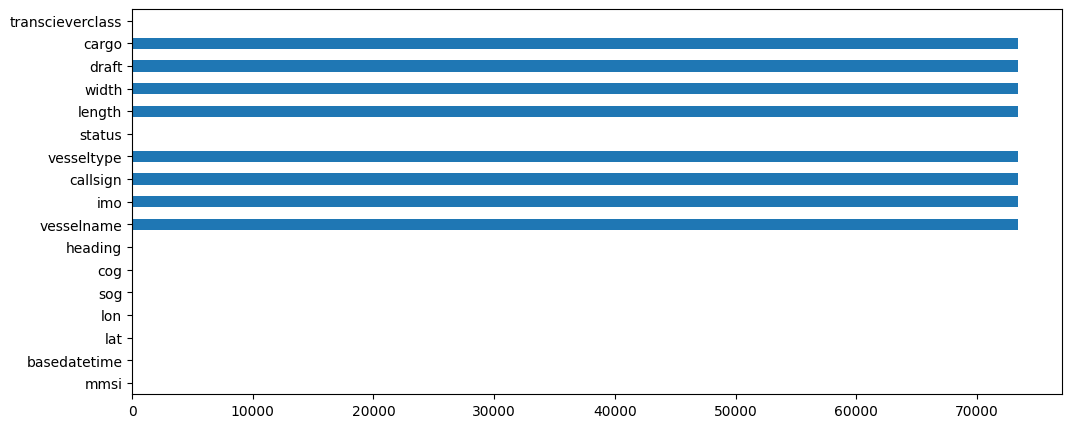

In [9]:
df_ais_pts.isnull().sum().plot(kind='barh', figsize=(12,5)) 
#属性cargo、draft、width、length、vesseltype、callsign、imo、vesselname都是空值，不可训练

In [10]:
df_mmsi=df_ais_pts['mmsi'].unique()
print(len(df_mmsi)) #一共有10条船的数据
df_mmsi

10


array([338999000, 265023000, 367348910, 368084090, 338143353, 372628000,
       563045300, 370039000, 368083770, 316001002], dtype=int64)

### 可视化

#### 对船舶轨迹可视化

In [ ]:
plot_traj_to_folium(df_mmsi[0]) # 红色：行迹折线，绿色：信息的坐标点

In [11]:
for i in range(10):
    m=plot_traj_to_folium(df_mmsi[i])
    #将所有船的轨迹在地图上可视化，并保存到html文件中
    m.save('data\output\plot_traj_mmsi={}.html'.format(df_mmsi[i]))

In [ ]:
plot_traj_point_scatter(df_mmsi[0])

#### 停留点分析

In [13]:
staypoints_for_mmsi(df_mmsi[0])

[(1609430522.0, 1609482122.0, -117.12025691285102, 32.666460251107836),
 (1609483132.0, 1609568193.0, -117.120257870754, 32.66642809444911),
 (1609571832.0, 1609632062.0, -117.12026948253569, 32.66646043984476),
 (1609632123.0, 1609652903.0, -117.12025628070181, 32.666470385964914),
 (1609653682.0, 1609655453.0, -117.1160088, 32.6608464),
 (1609655593.0, 1609727252.0, -117.12028447916688, 32.6664455104167),
 (1609740262.0, 1609825553.0, -117.12026746724915, 32.66646438427946),
 (1609827024.0, 1609859753.0, -117.12027191685915, 32.66644695150112)]

#### 停留点可视化

In [ ]:
plot_staypoints_map(df_mmsi[0])

In [15]:
for i in range(10):
    m=plot_staypoints_map(df_mmsi[i])
    #将所有船的停留点图像保存到html文件中
    m.save('data\output\plot_staypotints_mmsi={}.html'.format(df_mmsi[i]))

### 根据航行数据分析船舶航行路线

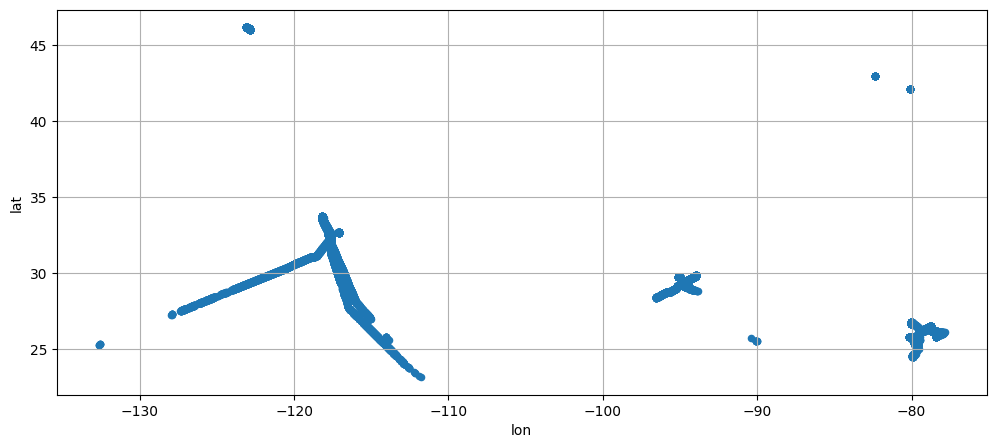

In [16]:
position_all = df_ais_pts[['lat','lon']] #10条船所有AIS信息中的位置坐标
position_all.plot.scatter(x='lon',y='lat',figsize=(12,5)).grid()

In [ ]:
# 提取一艘船所有的经纬度
#colors=['blue','cyan','green','black','magenta'	,'red','yellow','pink','brown','purple']
for i in range(10):
    plot_traj_point_scatter(df_mmsi[i])

In [20]:
mmsi=370039000 #df_mmsi[7]
traj = getTrajByMMSI(mmsi) # 轨迹简化
traj_simple = traj_simplify(traj)
position=np.array(traj_simple)[:,1:3] # 船的经纬度坐标，经度lon，纬度lat

In [22]:
# DBSCAN聚类，这里面的eps，min_sample参数人为调整
# 一般来说min_samples小，异常点少，但是过少会让算法认定所有数据都正常而无法聚类，eps小，聚的类多
db = DBSCAN(eps=0.1, min_samples=6).fit(position)

In [23]:
title = db.labels_ # 获得每个点对应的聚类结果的标签
title_list = list(set(list(title))) 
print("标签种类：",title_list)

# 统计各参数组合下的聚类个数（-1表示异常点）
n_clusters = len([i for i in set(db.labels_) if i != -1])
print("聚类个数：",n_clusters)

# 异常点的个数，如果异常点个数过多，则说明聚类效果不是特别好
outliners = np.sum(np.where(db.labels_ == -1, 1,0))
print("异常点个数：",outliners)

# 统计每个簇的样本个数
stats = pd.Series([i for i in db.labels_ if i != -1]).value_counts().values
print("每个簇的样本个数",stats)

标签种类： [0, 1, -1]
聚类个数： 2
异常点个数： 1
每个簇的样本个数 [2414  312]


In [24]:
df1=pd.DataFrame(position)
df1.columns = ['lon','lat']
df2=pd.DataFrame(title)
df2.columns = ['group']
position_1abel=pd.concat([df1,df2],axis=1) 
#将聚类得到的种类标签和坐标点合并
print(position_1abel.tail())

           lon       lat  group
2722 -78.44547  25.77250      0
2723 -78.44632  25.77130      0
2724 -78.44633  25.77125      0
2725 -78.44578  25.77157      0
2726 -78.44577  25.77162      0


#### 查看聚类情况（横坐标为经度，纵坐标为纬度）

In [ ]:
# 查看聚类情况（横坐标为经度，纵坐标为纬度）
position_1abel['group'].replace({0:'簇1',1:'簇2',-1:'异常点',2:'簇4',3:'簇5',4:'簇6'},inplace=True)
# 将分组后数值标签转换为文本标签

plt.rcParams['axes.unicode_minus']=False
#避免UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing，使图像中的中文和负号正常显示

sns.set_theme(context='notebook',style='darkgrid',
              palette='deep',font='SimHei',font_scale=1,rc=None)
#context参数：上下文参数，style参数：样式参数，palette参数：色盘参数

fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(111)
markers = {'簇1':'o','簇2':'X','异常点':'*','簇4':'o','簇5':'o','簇6':'o'}
sns.scatterplot(x='lon', y='lat', hue='group',
                data=position_1abel, markers=markers, style='group')
ax1.legend(title='',fontsize=10)
ax1.set_xlabel('经度',size=20)
ax1.set_ylabel('纬度',size=20)
plt.xticks(size=12)
plt.yticks(size=12)
plt.title('AIS轨迹(mmsi={})'.format(mmsi),size=30)
plt.tight_layout()
plt.savefig('data\output\AIS轨迹_mmsi={}.jpg'.format(mmsi),dpi=500)
plt.show()

### 预测路线GRU

#### 切分训练集和测试集

In [27]:
traj_simple[-5:]

[(1610756275.0, -78.44547, 25.7725),
 (1610771934.0, -78.44632, 25.7713),
 (1610773014.0, -78.44633, 25.77125),
 (1610775355.0, -78.44578, 25.77157),
 (1610775535.0, -78.44577, 25.77162)]

In [28]:
t_position=pd.DataFrame(position,index=np.array(traj_simple)[:,0])
t_position.tail()

,0,1
1.610756e+09,-78.44547,25.77250
1.610772e+09,-78.44632,25.77130
1.610773e+09,-78.44633,25.77125
1.610775e+09,-78.44578,25.77157
1.610776e+09,-78.44577,25.77162


In [29]:
t_position.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2727 entries, 1609438569.0 to 1610775535.0
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       2727 non-null   float64
 1   1       2727 non-null   float64
dtypes: float64(2)
memory usage: 63.9 KB


In [30]:
def load_data(data,look_back):
    data_raw = data.values #numpy array类型
    data = []
    for index in range(len(data_raw)-look_back):
        #从data_raw中截取长度为look_back的数据
        data.append(data_raw[index:index+look_back]) #使用list拼接数据集
    data = np.array(data) #再转化为numpy array类型
    #每隔60个数据点取一个样本，前59个数据点作为输入后一个作为输出
    
    test_set_size=int(np.round(0.2*data.shape[0])) #测试集占data的20%
    train_set_size=data.shape[0]-(test_set_size)
    
    x_train=torch.Tensor(data[:train_set_size,:-1,:]) #转化为张量
    y_train=torch.Tensor(data[:train_set_size,-1,:])
    x_test=torch.Tensor(data[train_set_size:,:-1,:])
    y_test=torch.Tensor(data[train_set_size:,-1,:])
    return [x_train,y_train,x_test,y_test]

In [31]:
x_train,y_train,x_test,y_test=load_data(t_position,look_back=60)
print("x_train.shape",x_train.shape)
print("x_test.shape",x_test.shape)
print("y_train.shape",y_train.shape)
print("y_test.shape",y_test.shape)

x_train.shape torch.Size([2134, 59, 2])
x_test.shape torch.Size([533, 59, 2])
y_train.shape torch.Size([2134, 2])
y_test.shape torch.Size([533, 2])


### 定义GRU模型

In [32]:
class GRU(nn.Module):
    def __init__(self,input_dim,hidden_dim,num_layers,output_dim):
        super(GRU,self).__init__()
        self.input_dim=input_dim
        self.hidden_dim=hidden_dim
        self.num_layers=num_layers
        self.output_dim=output_dim
        
        self.gru=nn.GRU(input_dim,hidden_dim,num_layers,batch_first=True)
        self.fc=nn.Linear(hidden_dim,output_dim)
    def forward(self,x):
        h0=torch.zeros(self.num_layers,x.size(0),self.hidden_dim).requires_grad_()
        out,hn=self.gru(x,h0.detach())
        #hn：隐藏状态，hidden state 
        out=self.fc(out[:,-1,:])
        return out

In [33]:
model=GRU(input_dim=2,hidden_dim=32,num_layers=2,output_dim=2)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

In [34]:
y_train

tensor([[-78.2664,  25.8726],
        [-78.2372,  25.8851],
        [-78.2321,  25.8873],
        ...,
        [-80.1678,  25.7762],
        [-80.1678,  25.7762],
        [-80.1678,  25.7762]])

#### 训练模型

In [35]:
def eculidDisSim(x,y):
    '''一维数据的欧几里距离
    两个向量之间的距离特别小时相似度高，反之相似度不高。'''
    return np.sqrt(sum(pow(a-b,2) for a,b in zip(x,y)))

In [ ]:
num_epochs=600 # 数据没有归一化,所以loss数值会较大
hist=np.zeros(num_epochs)
dist_list=np.zeros(num_epochs)
scr_list=np.zeros(num_epochs)
print("GRU's training(mmsi={})".format(mmsi))
for t in range(num_epochs):
    y_train_pred=model(x_train)
    loss=loss_fn(y_train_pred,y_train)
    dist=eculidDisSim(y_train_pred.detach().numpy(),y_train.detach().numpy())
    score=(dist[0]+dist[1])/2
    if t%10==0 and t!=0:
        print("Epoch:",t,"     MSE:{:6f}     dist:{}     score:{:6f}".format(loss.item(),dist,score))
    hist[t]=loss.item()
    scr_list[t]=score.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

####  绘制训练结果图像

In [ ]:
#将loss和acc列表归一化，方便可视化
hist_max=max(hist)
for i in range(len(hist)):
    hist[i]=hist[i]/hist_max
    
acc_max=max(scr_list)
for i in range(len(scr_list)):
    scr_list[i]=scr_list[i]/acc_max

In [ ]:
fig = plt.figure() 
plt.plot(range(num_epochs),hist[range(num_epochs)], label='Train Loss')
plt.xlabel("epochs")
plt.title("MSELoss per epoch (mmsi={})".format(mmsi))
plt.grid()

fig = plt.figure()
plt.plot(range(num_epochs),scr_list[range(num_epochs)], label='Train Score')
plt.xlabel("epochs")
plt.title("Score per epoch (mmsi={})".format(mmsi))
plt.grid()

plt.show()

#### 测试

In [ ]:
model.eval()#测试集不需要多个epoch
print("mmsi:",mmsi)
y_test_pred = model(x_test) # 对测试数据执行预测
test_loss=loss_fn(y_test_pred,y_test)
score = eculidDisSim(y_test_pred.detach().numpy(),y_test.detach().numpy())
test_score=(score[0]+score[1])/2 
print('Test Loss: {:.6f}'.format( test_loss))
print('Test Score: {:.3f}'.format( test_score))

In [ ]:
print("mmsi:",mmsi)
print("真实值：",y_test[1]) 
print("预测值：",y_test_pred[1]) 

#print hello